In [1]:
import pandas as pd
import numpy as np
import os
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords
import string
from collections import Counter, defaultdict
import pickle
from nltk import bigrams
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA

In [31]:
STOPWORDS = stopwords.words("english")
PUNCTUATION = list(string.punctuation) + ["``", "''", "--"]
SYNONYM_PAIRS_FILE = "synonym_pairs.txt"
ANALOGY_TEST_FILE = "word-test.v1.txt"

# Helper Functions

In [ ]:
def load_synonym_pairs():
    with open(SYNONYM_PAIRS_FILE, "r") as file:
        data = file.readlines()
        data = [line.strip().split(" ") for line in data]
        data = {(line[0], line[1]): float(line[2]) for line in data if len(line) == 3}
    # Check the number of pairs is correct
    assert len(data) == 65
    return data

In [3]:
def load_synonym_pairs():
    with open(SYNONYM_PAIRS_FILE, "r") as file:
        data = file.readlines()
        data = [line.strip().split(" ") for line in data]
        data = {(line[0], line[1]): float(line[2]) for line in data if len(line) == 3}
    # Check the number of pairs is correct
    assert len(data) == 65
    return data

def preprocess_brown_corpus(corpus):
#     (word.lower() not in STOPWORDS) and 
    c = [word.lower() for word in corpus if (word not in PUNCTUATION)]
    return c

In [4]:
# nltk.download('brown')
brown_corpus = nltk.corpus.brown.words()
syn_pairs = load_synonym_pairs()

# Preprocessing
To preprocess the data, I apply the typical preprocessing steps of removing punctuation and converting all words to lower case. I removed all instances of punctuation as they do not aid a model's ability to perform a word similarity task. In addition, since we have no reason to distinguish proper nouns from common nouns in our use case, I lowercase the data so that we have more data to work with (as now words like "city" and "City" will be treated as the same term).

In [5]:
# Total length of the corpus
print(f"The total length of the brown corpus is {len(brown_corpus)} words")
preproc_corpus = preprocess_brown_corpus(brown_corpus)
print(f"The total length of the brown corpus is {len(preproc_corpus)} words")

The total length of the brown corpus is 1161192 words
The total length of the brown corpus is 1013320 words


# Constructing LSA Model from Basic Exercise

In [6]:
def extract_token_counts(corpus):
    c = Counter(corpus)
    pairs = [(word, c[word]) for word in c]
    return sorted(pairs, key=lambda x: x[1])[-1:-5001:-1]

In [7]:
# Extract frequencies for each token
token_counts = extract_token_counts(preproc_corpus)
N_most_common = 5
print("Most common terms:")
for pair in token_counts[:N_most_common]:
    print(f"{pair[0]} (n={pair[1]})")
print("\nLeast common terms:")
for pair in token_counts[-1:-N_most_common-1:-1]:
    print(f"{pair[0]} (n={pair[1]})")

Most common terms:
the (n=69971)
of (n=36412)
and (n=28853)
to (n=26158)
a (n=23195)

Least common terms:
rourke (n=19)
killpath (n=19)
haney (n=19)
letch (n=19)
allen (n=20)


In [10]:
W = [pair[0] for pair in token_counts]
print(f"Number of words in W: {len(W)}")

rg_65_words = list(set(sum(syn_pairs, ())))
W = list(set(W).union(rg_65_words))
print(f"Number of words in W: {len(W)}")

Number of words in W: 5000
Number of words in W: 5031


In [11]:
all_bigrams = list(bigrams(preproc_corpus))
attested_bigrams = []#defaultdict(lambda: 0)
for bigram in tqdm(all_bigrams, total=len(list(all_bigrams))):
    w1, w2 = bigram
    if w1 in W:
        if w2 in W:
            attested_bigrams.append((w1, w2))
attested_bigrams = Counter(attested_bigrams)

100%|██████████| 1013319/1013319 [01:56<00:00, 8661.04it/s]


In [12]:
def get_mappings(all_words):
    token2idx = {all_words[i]: i for i in range(len(all_words))}
    idx2token = {val: key for key, val in token2idx.items()}
    return token2idx, idx2token

def get_cooccurence(word_1, word_2, matrix, token2idx):
    idx_1 = token2idx[word_1]
    idx_2 = token2idx[word_2]
    return matrix[idx_1, idx_2]

token2idx, idx2token = get_mappings(list(W))

data = []
rows = []
cols = []
for word_1 in W:
    for word_2 in W:
        val = attested_bigrams.get((word_1, word_2), 0)
        data.append(val)
        rows.append(token2idx[word_1])
        cols.append(token2idx[word_2])

m1 = csr_matrix((data, (rows, cols)))

In [13]:
def compute_ppmi(model):
    joint = (model/model.sum()).todense()
    px = joint.sum(axis=0)
    py = joint.sum(axis=1)
    ind_joint = (px.T@py.T)
    div = np.divide(joint, ind_joint, out=np.zeros_like(joint), where=ind_joint!=0)
    pmi = np.log2(div)
    ppmi = np.where(pmi>0, pmi, 0)
    return ppmi

In [14]:
ppmi = compute_ppmi(m1)

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys


In [25]:
true = []
for key in syn_pairs:
    true.append(syn_pairs[key])
    
def get_model_preds(model, pair):
    w1, w2 = pair
    e1 = model[token2idx[w1]].reshape(1, -1)
    e2 = model[token2idx[w2]].reshape(1, -1)
    pred = cosine_similarity(e1, e2)[0][0]
    return pred

In [57]:
m1_preds = [get_model_preds(m1, pair) for pair in syn_pairs]
print(f"Word-Contex Vector Correlation: ", np.round(pearsonr(true, m1_preds)[0], 2))

print("Fitting 10 dim")
pca_10 = PCA(n_components=10)
m2_10 = pca_10.fit_transform(ppmi)
m2_10_preds = [get_model_preds(m2_10, pair) for pair in syn_pairs]
print(f"10 Dimensional LSA Correlation: ", np.round(pearsonr(true, m2_10_preds)[0], 2))

print("Fitting 100 dim")
pca_100 = PCA(n_components=100)
m2_100 = pca_100.fit_transform(ppmi)
m2_100_preds = [get_model_preds(m2_100, pair) for pair in syn_pairs]
print(f"100 Dimensional LSA Correlation: ", np.round(pearsonr(true, m2_100_preds)[0], 2))

print("Fitting 300 dim")
pca_300 = PCA(n_components=300)
m2_300 = pca_300.fit_transform(ppmi)
m2_300_preds = [get_model_preds(m2_300, pair) for pair in syn_pairs]
print(f"300 Dimensional LSA Correlation: ", np.round(pearsonr(true, m2_300_preds)[0], 2))

Word-Contex Vector Correlation:  0.23
Fitting 10 dim
10 Dimensional LSA Correlation:  0.13
Fitting 100 dim
100 Dimensional LSA Correlation:  0.31
Fitting 300 dim
300 Dimensional LSA Correlation:  0.36


# Assignment Part 1: Synchronic word embedding

In [115]:
w2v_model = KeyedVectors.load_word2vec_format('/ais/hal9000/datasets/wordembeddings/google_news_w2v.bin', binary=True)

Step 2: Using gensim, extract embeddings of words in Table 1 of RG65 that also appeared in
the set Wfrom the earlier exericse, i.e., the pairs of words should be identical in all analyses.

In [20]:
def word_to_embedding(words, model):
    word2embedding = {}
    for word in words:
        word2embedding[word] = model[word]
    return word2embedding

In [21]:
word2embedding = word_to_embedding(rg_65_words, w2v_model)

Step 3. Calculate cosine distance between each pair of word embeddings you have extracted,
and report the Pearson correlation between word2vec-based and human similarities. [1 point]
Comment on this value in comparison to those from LSA and word-context vectors from analyses in the earlier exercise.

In [22]:
# Calculate cosine similarity
true_vals = []
pred_vals = []
for pair in syn_pairs:
    w1, w2 = pair
    w1_e = word2embedding[w1].reshape(1, -1)
    w2_e = word2embedding[w2].reshape(1, -1)
    cos_sim = cosine_similarity(w1_e, w2_e)[0][0]
    
    true_vals.append(syn_pairs[pair])
    pred_vals.append(cos_sim)

In [54]:
# Report pearson correlation
corr, p_val = pearsonr(true_vals, pred_vals)
print(np.round(corr, 2))

0.77


The correlation of the Word2Vec embeddings with the human judgements is much higher than that of both the word-context vectors and the LSA embeddings. The correlations are 0.23 for the word-context vectors, and 0.13, 0.31, and 0.36 for the 10, 100, and 300 dimensional LSA models respectively. For the Word2Vec model, our correlation is 0.77. The fact that the Word2Vec model predictions better correlate with human judgements is sensible, as the word-context vectors and the LSA embeddings are derived from the raw count data, where as the Word2Vec model is trained to learn high quality embeddings for words.

# Task 4: Analogy Test

Step 4. Perform the analogy test based on data here (or as provided) with the pre-trained
word2vec embeddings. Report the accuracy on the semantic analogy test and the syntactic
analogy test (see Note below). [2 points] 

Repeat the analysis with LSA vectors (300 dimensions) from the earlier exercise, and commment on the results in comparison to those from word2vec. [1 point]

Note: It is expected that the number of entries you could test with LSA
would be smaller than that based on word2vec. For a fair comparison, you should consider
reporting model accuracies based on the small test set, for both word2vec and LSA.

First, we must limit the set of analogies to those that use words present in the LSA vocabulary. We can do so with the following function.

In [61]:
def load_analogy_test(word_set):
    with open(ANALOGY_TEST_FILE, "r") as file:
        data = file.readlines()
        data = [line.strip().split(" ") for line in data]
        data = [list(map(str.lower, line)) for line in data if len(line) == 4]
        data = [line for line in data if (all(word in word_set for word in line))]
    return data

analogies = load_analogy_test(set(W))
with open("parsed_analogies.txt", "w") as file:
    for line in analogies:
        file.write(" ".join(line))
        file.write("\n")

Once we find the subset of analogies that will work in both Word2Vec and our LSA model, we can split them into semantic and syntactic analogy sets based on the original file. Also, to make the LSA model comparable to Word2Vec, we can convert it to a KeyedVectors object.

In [116]:
lsa = KeyedVectors(300)
lsa.add_vectors(W, m2_300)

In [117]:
def perform_analogy_test(analogies, model):
    correct = 0
    for i in tqdm(range(len(analogies))):
        analogy = analogies[i]
        a, b, c, d = analogy
        pred = model.most_similar(positive=[b, c], negative=[a])[0][0]
        if d == pred:
            correct += 1
    return correct/len(analogies)



with open("semantic_analogies.txt", "r") as file:
    semantic_analogies = file.readlines()
    semantic_analogies = [line.strip().split(" ") for line in semantic_analogies]
lsa_semantic = perform_analogy_test(semantic_analogies, lsa)
w2v_semantic = perform_analogy_test(semantic_analogies, w2v_model)

with open("syntactic_analogies.txt", "r") as file:
    syntactic_analogies = file.readlines()
    syntactic_analogies = [line.strip().split(" ") for line in syntactic_analogies]
lsa_syntactic = perform_analogy_test(syntactic_analogies, lsa)
w2v_syntactic = perform_analogy_test(syntactic_analogies, w2v_model)

100%|██████████| 2045/2045 [05:15<00:00,  6.48it/s]


In [120]:
print(f"Accuracy of LSA on semantic analogies: {np.round(lsa_semantic, 2)}")
print(f"Accuracy of LSA on syntactic analogies: {np.round(lsa_syntactic, 2)}")
print(f"Accuracy of Word2Vec on semantic analogies: {np.round(w2v_semantic, 2)}")
print(f"Accuracy of Word2Vec on syntactic analogies: {np.round(w2v_syntactic, 2)}")

Accuracy of LSA on semantic analogies: 0.17
Accuracy of LSA on syntactic analogies: 0.08
Accuracy of Word2Vec on semantic analogies: 0.66
Accuracy of Word2Vec on syntactic analogies: 0.67


Step 5. Suggest a way to improve the existing set of vector-based models in capturing word
similarities in general, and provide justifications for your suggestion.

For word similarity tasks, one thing that our current vector models miss out on is the particular sense of the word being used. Through context (the paired word in the Rubenstein & Goodenough (1965) task), humans can determine the sense of the word that is required to make similarity judgements. For instance, take the pair (asylum, madhouse). Here, through the use of the word "madhouse", humans can infer we care about the sense of the word "asylum" that refers to a psychiatric hospital. However, if we instead showed the pair (asylum, refuge), humans would understand that we are now referring to a different sense of the word "asylum" used for political refugees. In both cases, the word "asylum" would be quite similar to the paired word.

The models we've used thusfar are static, and so have one sense of the word "asylum". So, it is possible that our models find one pair to be more similar than the other because a particular word sense dominated its training data. To improve our models, we ought to take context into account. One way to do this would be by using a contextual model such as BERT, and finding a prototypical vector for each of a word's senses using a variety of contextual usages of a word. 

Referring back to the case above, we could show the model many cases of the word "asylum" used in both of its senses, and then create a prototypical vector for each sense cluster. We could then treat these two prototypical sense vectors as distinct vectors for the model and find the embedding that has the highest cosine similarity with the paired word. This would make the vector models more accurate in making word similarity judgements.

# Assignment Part 1: Diachronic word embedding

In [160]:
with open("data.pkl", "rb") as file:
    diachronic = pickle.load(file)

In [161]:
words = diachronic['w'] #2000
decades = diachronic['d']
embeddings = diachronic['E'] #num_words X num_decades X dim_size (300)

We need to get the year of the first embedding available for a given word, as certain words are not available in the first 1-2 decades.

In [162]:
def get_year_of_first_embedding(embeddings):
    word_to_first_embedding = {}
    for i in range(len(embeddings)):
        for j in range(len(embeddings[i])):
            if all(embeddings[i][j]):
                word_to_first_embedding[words[i]] = j 
                break
    return word_to_first_embedding
            

In [190]:
def report_most_least_changed(reordered_scores, reordered_words):
    zipped = list(zip(reordered_scores, reordered_words))
    least = zipped[:20]
    most = zipped[-20:]
    print("MOST")
    for pair in least:
        print(f"Word: {pair[1]} Change: {np.round(pair[0], 3)}")
        
    print("LEAST")
    for pair in most:
        print(f"Word: {pair[1]} Change: {np.round(pair[0], 3)}")

In [191]:
def sort_semantic_change(change, words):
    words = np.asarray(words)
    least_most = np.argsort(change)
    reordered_scores = change[least_most]
    reordered_words = words[least_most]
    report_most_least_changed(reordered_scores, reordered_words)
    return reordered_scores, reordered_words

In [192]:
def semantic_displacement(embeddings, words, word_to_first_embedding):
    net_change = []
    for idx in range(len(embeddings)):
        subset = np.asarray(embeddings[idx]).reshape(len(decades), -1)
        subset = subset[word_to_first_embedding[words[idx]]:, :]
        change_over_time = cosine_similarity(subset, subset)
        net_change.append(change_over_time[0][-1])
    net_change = np.asarray(net_change)
    return net_change

In [193]:
def semantic_drift(embeddings, words, word_to_first_embedding):
    mean_change = []
    for idx in range(len(embeddings)):
        subset = np.asarray(embeddings[idx]).reshape(len(decades), -1)
        subset = subset[word_to_first_embedding[words[idx]]:, :]
        dists = []
        for i in range(len(subset)):
            if (all(subset[i])):
                dist = cosine_similarity(subset[i].reshape(1, -1), subset[0].reshape(1, -1))
                dists.append(dist[0][0])
        mean = np.mean(dists)
        mean_change.append(mean)
    mean_change = np.asarray(mean_change)
    return mean_change

In [194]:
def semantic_volatility(embeddings, words, word_to_first_embedding):
    mean_change = []
    for idx in range(len(embeddings)):
        subset = np.asarray(embeddings[idx]).reshape(len(decades), -1)
        subset = subset[word_to_first_embedding[words[idx]]:, :]
        dists = []
        for i in range(len(subset)-1):
            if (all(subset[i])) and (all(subset[i+1])):
                dist = cosine_similarity(subset[i].reshape(1, -1), subset[i+1].reshape(1, -1))
                dists.append(dist[0][0])
        mean = np.mean(dists)
        mean_change.append(mean)
    mean_change = np.asarray(mean_change)
    return mean_change

In [195]:
word_to_first_embedding = get_year_of_first_embedding(embeddings)

In [196]:
m1 = semantic_displacement(embeddings, words, word_to_first_embedding)
m1_scores, m1_words = sort_semantic_change(m1, words)

MOST
Word: programs Change: 0.009
Word: objectives Change: 0.022
Word: computer Change: 0.039
Word: radio Change: 0.095
Word: sector Change: 0.099
Word: goals Change: 0.155
Word: approach Change: 0.16
Word: van Change: 0.163
Word: shri Change: 0.176
Word: media Change: 0.187
Word: impact Change: 0.2
Word: perspective Change: 0.207
Word: patterns Change: 0.218
Word: berkeley Change: 0.222
Word: shift Change: 0.223
Word: film Change: 0.224
Word: assessment Change: 0.232
Word: stanford Change: 0.233
Word: challenge Change: 0.234
Word: therapy Change: 0.239
LEAST
Word: miles Change: 0.674
Word: payment Change: 0.677
Word: door Change: 0.678
Word: evening Change: 0.678
Word: week Change: 0.68
Word: feet Change: 0.681
Word: september Change: 0.682
Word: god Change: 0.685
Word: december Change: 0.686
Word: daughter Change: 0.688
Word: months Change: 0.69
Word: century Change: 0.693
Word: january Change: 0.698
Word: increase Change: 0.699
Word: october Change: 0.703
Word: years Change: 0.709
W

In [197]:
m2 = semantic_drift(embeddings, words, word_to_first_embedding)
m2_scores, m2_words = sort_semantic_change(m2, words)

MOST
Word: objectives Change: 0.147
Word: programs Change: 0.166
Word: computer Change: 0.184
Word: radio Change: 0.251
Word: sector Change: 0.274
Word: goals Change: 0.293
Word: shri Change: 0.337
Word: therapy Change: 0.361
Word: van Change: 0.37
Word: mcgraw Change: 0.375
Word: input Change: 0.379
Word: patterns Change: 0.384
Word: evaluation Change: 0.389
Word: berkeley Change: 0.393
Word: jobs Change: 0.401
Word: wiley Change: 0.405
Word: stanford Change: 0.409
Word: wilson Change: 0.418
Word: jones Change: 0.421
Word: technology Change: 0.43
LEAST
Word: daughter Change: 0.766
Word: payment Change: 0.767
Word: century Change: 0.772
Word: church Change: 0.773
Word: june Change: 0.777
Word: december Change: 0.777
Word: vessels Change: 0.778
Word: years Change: 0.779
Word: increase Change: 0.779
Word: months Change: 0.779
Word: july Change: 0.779
Word: feet Change: 0.78
Word: trees Change: 0.783
Word: february Change: 0.788
Word: january Change: 0.791
Word: september Change: 0.794
Wo

In [198]:
m3 = semantic_volatility(embeddings, words, word_to_first_embedding)
m3_scores, m3_words = sort_semantic_change(m3, words)

MOST
Word: harper Change: 0.578
Word: jones Change: 0.578
Word: sector Change: 0.592
Word: berkeley Change: 0.598
Word: wiley Change: 0.598
Word: baltimore Change: 0.601
Word: martin Change: 0.601
Word: princeton Change: 0.602
Word: wilson Change: 0.611
Word: adams Change: 0.611
Word: therapy Change: 0.62
Word: johnson Change: 0.62
Word: goals Change: 0.621
Word: haven Change: 0.625
Word: philip Change: 0.625
Word: evaluation Change: 0.625
Word: j Change: 0.626
Word: publications Change: 0.643
Word: stanford Change: 0.644
Word: maryland Change: 0.648
LEAST
Word: blood Change: 0.82
Word: patients Change: 0.821
Word: june Change: 0.822
Word: buildings Change: 0.822
Word: temperature Change: 0.825
Word: october Change: 0.827
Word: decrease Change: 0.827
Word: july Change: 0.828
Word: solution Change: 0.828
Word: cent Change: 0.829
Word: trees Change: 0.831
Word: vessels Change: 0.831
Word: university Change: 0.831
Word: february Change: 0.833
Word: december Change: 0.84
Word: january Chan

In [199]:
pearson_corrs = pd.DataFrame({"Semantic Displacement": m1, "Semantic Drift": m2, "Semantic Volatility": m3}).corr(method='pearson')
pearson_corrs

,Semantic Displacement,Semantic Drift,Semantic Volatility
Semantic Displacement,1.000000,0.900806,0.678416
Semantic Drift,0.900806,1.000000,0.789278
Semantic Volatility,0.678416,0.789278,1.000000


In [247]:
def changepoint_detection(test_words):
    mean_change = []
    for word in test_words:
        idx = words.index(word)
        subset = np.asarray(embeddings[idx]).reshape(len(decades), -1)
        subset = subset[word_to_first_embedding[words[idx]]:, :]
        dists = []
        most_recent_embedding = subset[0]
        for i in range(len(subset)-1):
            if (all(most_recent_embedding)) and (all(subset[i+1])):
                dist = cosine_similarity(subset[i].reshape(1, -1), subset[i+1].reshape(1, -1))
                dists.append(dist[0][0])
                most_recent_embedding = subset[i+1]
            else:
                if len(dists) == 0:
                    dists.append(1)
                else:
                    dists.append(dists[-1])
        mean_change.append(dists)
    return mean_change

In [248]:
test_words = ["computer", "program", "objectives"]
mean_change = changepoint_detection(test_words)

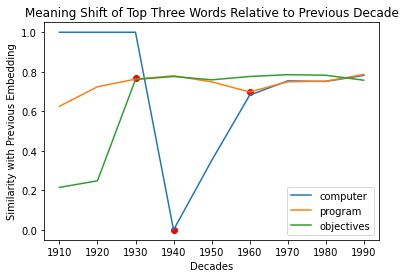

In [249]:
plt.plot(decades[1:], mean_change[0], label=test_words[0])
plt.plot(decades[1:], mean_change[1], label=test_words[1])
plt.plot(decades[1:], mean_change[2], label=test_words[2])
plt.legend()
plt.xlabel("Decades")
plt.ylabel("Similarity with Previous Embedding")
plt.title("Meaning Shift of Top Three Words Relative to Previous Decade")
plt.scatter([1940, 1930, 1960], [0, 0.77, 0.70], color="red")

For this change point detection algorithm, we can simply calculate the degree to which each decade's embedding is similar to the embedding from the previous decade. If the similarity is high between a pair of consecutive decades, this suggests that the word has not experienced a large shift in meaning. Conversely, if we see a dip in cosine similarity in a particular decade, this would tell us that the word has experienced a meaning shift at that point in time, and thus that this is our change point. The red points show change points detected by the algorithm.

For the word "computer", we see that this happens in 1940s, when it acquires a more digital meaning. The word "program" seems to experience a shift around 1960, which is sensible as it occurs after computers become more ubiquitous. Finally, the word "objectives" seems to experience its change point in the 1930s. I'm not sure why this would be the case, though it could be the case that the word took on a more militaristic meaning given the prevalence of the World Wars during these decades.